# 3DeeCellTracker Demo: Single mode | Use StarDist


This notebook shows how to use 3DeeCellTracker to track cells in single mode. The segmentation is basded on the trained StarDist.

**Use the environment "tf2" for this notebook"**

To do this, import the tf2.yml file into your Home directory. Open it and change the prefix /rds/general/user/ecd24/home/anaconda3/envs/tf2 to your own (usually, you just need to change ecd24 to your username). Open a terminal and execute the command 'conda env create -f tf2.yml'.

The demo data and pre-trained deep neural network models can be found in the "worm1", "stardist_models" and "ffn_models" folders downloaded from https://osf.io/pgr95/

## The basic procedures:

A - Import packages

B - Segment cells by StarDist3D

C - Load manually corrected segmentation (t=1)

D - Track cells by FFN + PRGLS + Fine-tune.

E - Extract activities from the tracked cells.

F - Build the 3D time-lapse labelled image.

# 0 - GPU support

In [1]:
import tensorflow as tf

tf.config.list_physical_devices(
    device_type=None
)

2024-07-08 12:01:53.427815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-08 12:02:22.366995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-07-08 12:02:22.437698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:e1:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2024-07-08 12:02:22.437754: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-08 12:02:22.928746: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-07-08 12:02:22.928802: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-07-08 12:02:23.059931: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2024-07-08 12:02:23.253132: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcurand.so

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# A - Import packages

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
import numpy as np

import CellTracker.trackerlite as trl
import CellTracker.stardistwrapper as sdw
import CellTracker.coord_image_transformer as cit
from CellTracker.analyses import draw_signals

2024-07-10 11:10:51.181053: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# B - Segment cells by StarDist3D
## Load trained StarDist3D model
## Parameters
model_name: A string specifying the name of the model to reload.
## Notes:
By default, the function looks for the model with the specified name from the stardist_models directory. However, if you have saved the model in a different location, you can specify the basedir parameter to load the model from that directory.

    model = sdw.load_stardist_model(model_name=stardist_model_name, basedir=".\FolderA\FolderB\")

In [2]:
stardist_model_name = "stardist_worm1"

model = sdw.load_stardist_model(model_name=stardist_model_name)

2024-07-10 11:11:36.524241: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-07-10 11:11:36.590644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2024-07-10 11:11:36.590713: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-10 11:11:36.957244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-07-10 11:11:36.957334: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-07-10 11:11:37.052883: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.450644, nms_thresh=0.3.
Load pretrained stardist model 'stardist_worm1' from folder 'stardist_models'


## Segment the volume #1 image and save the segmentation in auto_vol1 folder
## Parameters
path_results: A string specifying a directory to save the segmentation/tracking results.

path_raw_images: A string specifying the file path to the raw images. The raw images could be a TIFF image sequence, or an HDF5 file with the data stored in "raw_images" key.
## Notes
All of the time-lapse 3D images should be stored in a single directory. Each 3D image at time t should be saved as a sequence of 2D slices in TIFF format. The filename of each 2D image should contain the timing and slice number, such as "xxx_txxx_z_xxx.tif". To ensure that the program correctly loads the images for each timing, users should specify the format of the timing in the filename in the path_raw_images parameter. For example, "t%03d.tif" indicates that the filename should contain the letter "t" followed by a 3-digit number representing the timing, followed by any number of characters, and ending with the extension ".tif".

In [ ]:
# Initialisations

num_slices = 201 
length_cycle_with_max_freq = 92
height = 320
width = 300

In [2]:
#Packages 

import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np
import scipy.stats 

In [3]:
ThreeDImage_dict = {} 
file_path = '3d_with_time_heart_LoG.ome.tif'
image = imageio.volread(file_path)

print(image.shape)

for t in range(length_cycle_with_max_freq):
    slice_at_t = image[t,:,:,:]
    for z in range (num_slices):
        ThreeDImage_dict[f'aligned_t{t:03}_z{z:03}']= slice_at_t[z, :, :]
        imageio.imwrite(f'worm1/data/aligned_t{t:03}_z{z:03}.tif', ThreeDImage_dict[f'aligned_t{t:03}_z{z:03}'])
        if ThreeDImage_dict[f'aligned_t{t:03}_z{z:03}'].shape != (height, width) :
            print(ThreeDImage_dict[f'aligned_t{t:03}_z{z:03}'].shape)

(92, 201, 320, 300)


In [7]:
os. getcwd()

'/rds/general/user/ecd24/home'

Raw image shape at vol1: (201, 320, 300)


2024-07-10 11:12:16.958810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-07-10 11:12:16.971536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2250185000 Hz
2024-07-10 11:12:17.731016: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-07-10 11:12:20.704250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2024-07-10 11:12:25.190891: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-10 11:12:25.190952: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2024-07-10 11:12:25.191413: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-10 11:12:25.191527: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

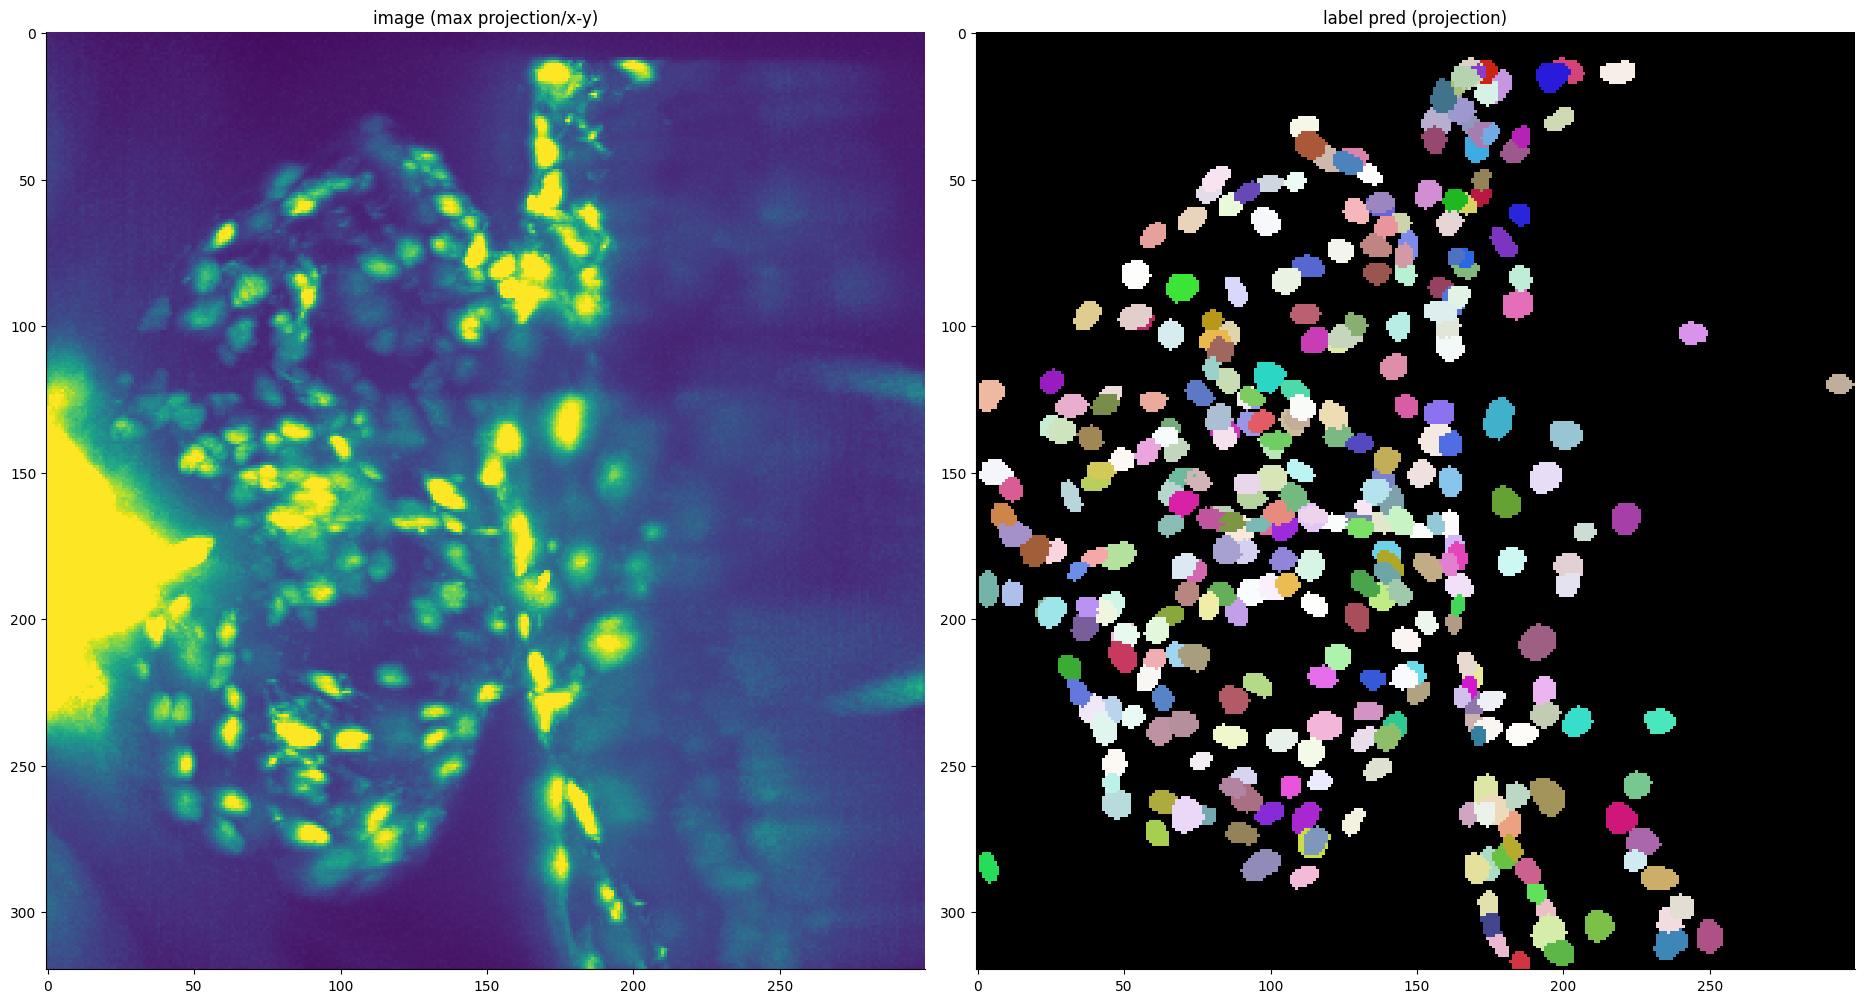

In [4]:
path_results = "./worm1/"
path_raw_images = "./worm1/data/*t%03d*.tif"

vol = 0
x = sdw.load_2d_slices_at_time(path_raw_images, t=vol)

print(f"Raw image shape at vol1: {x.shape}")

(labels, details), prob_map = model.predict_instances(x)
use_8_bit = True if labels.max() <= 255 else False

sdw.plot_img_label_max_projection(x, labels, lbl_title="label pred (projection)", fig_width_px=1800)

## Displaying max projections of raw images and predicted segmentation in x-z plane
## Parameters
scale_z: A number (>0) specifying the scaling rate along the z-axis. This is useful when the resolution in the z-axis is significantly different from that in the x-axis.

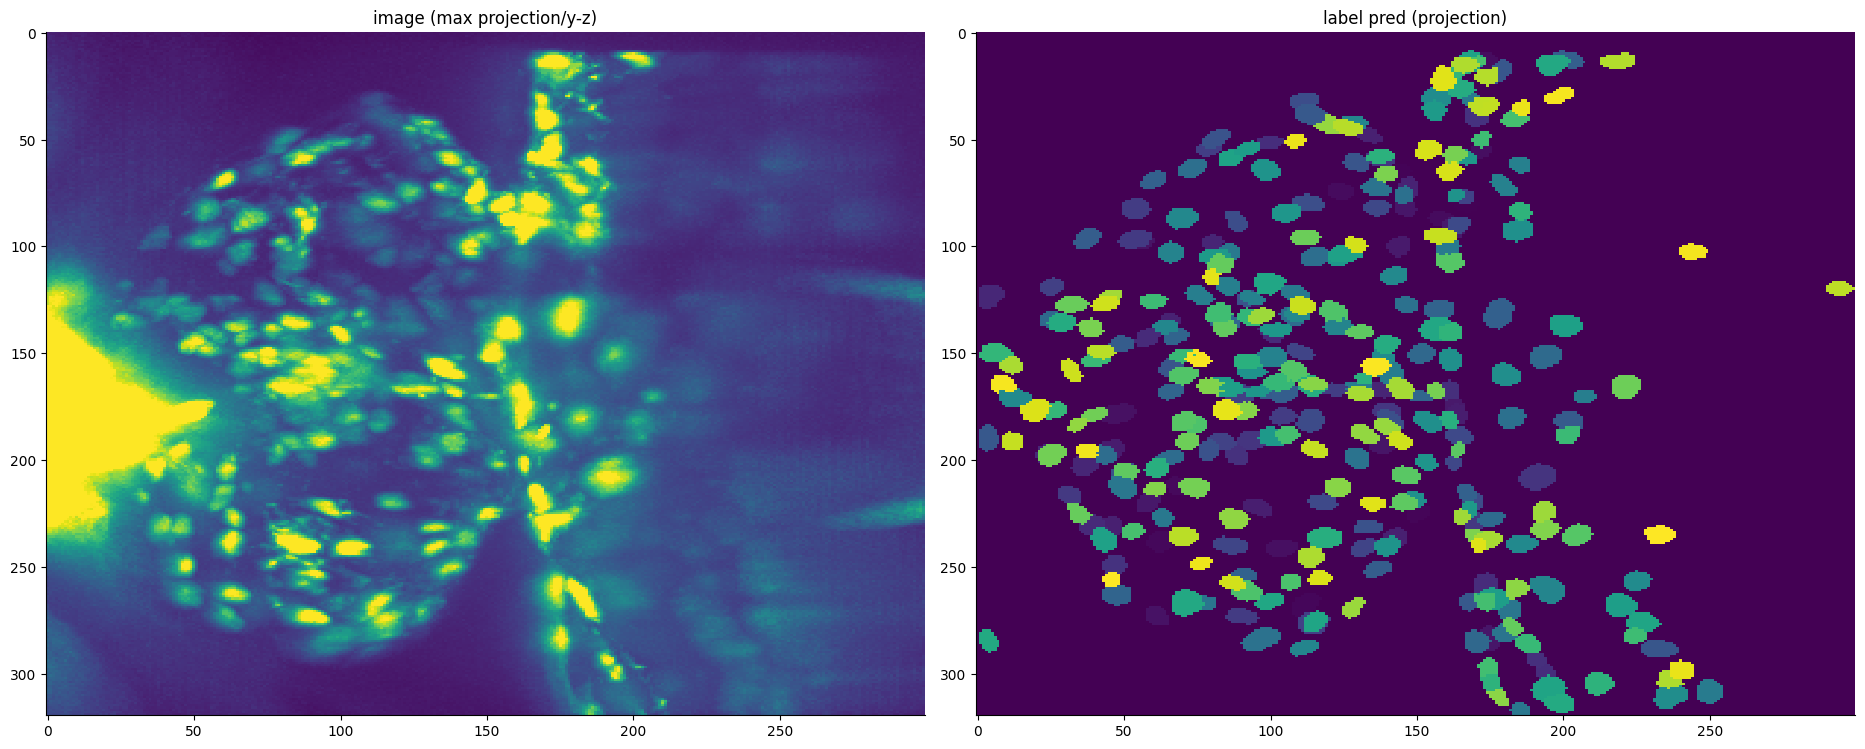

In [5]:
scale_y = 0.729

sdw.plot_img_label_max_projection_yz(x, labels, lbl_title="label pred (projection)", fig_width_px=1800, scale_y=scale_y)

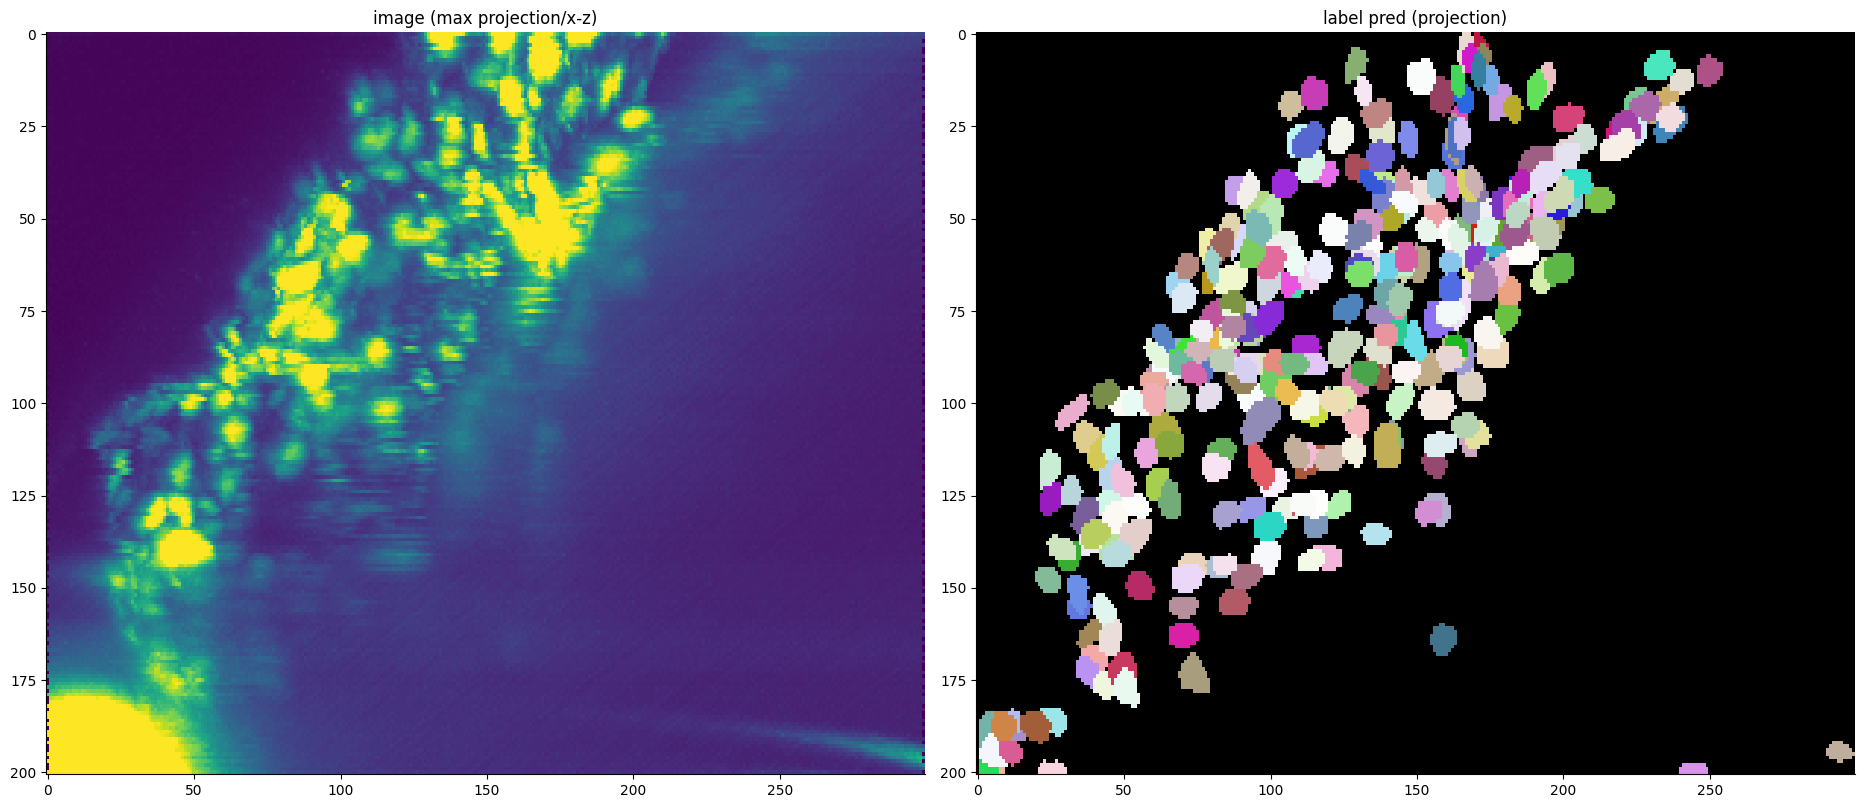

In [6]:
scale_z = 1.26

sdw.plot_img_label_max_projection_xz(x, labels, lbl_title="label pred (projection)", fig_width_px=1800, scale_z=scale_z)

## Segment all volumes
The following code block segments cells in all volumes and saves the predicted cell coordinates and probability maps in the "seg" folder automatically.

In [7]:
sdw.predict_and_save(images_path=path_raw_images, model=model, results_folder=path_results)

Segmenting images: 100%|█| 92/92 [14:13<00:00,  9.

All images from t=0 to t=91 have been Segmented


# C - Manual correction
## Perform manual correction

Save the first volume in a 3D file to perform manual segmentation

In [7]:
import imageio
import numpy as np
import skimage.io as io

slices_dataset = []

for z in range(1,num_slices +1):
    tiff_file_path = f'worm1/auto_vol1/auto_vol1_z{z:04}.tif'
    tiff_data = imageio.volread(tiff_file_path)
    slices_dataset.append(tiff_data)

slices_dataset = np.asarray(slices_dataset)  # ZTYX
print(slices_dataset.shape)

# imageio.imwrite(f'worm1/manual_vol1/manual_correction.tif', slices_dataset)
io.imsave(f'worm1/auto_vol1_processing/vol1_for_manual_correction.tif', slices_dataset.astype('uint16'), imagej=True) 

(201, 320, 300)


Manually correct the segmentation results saved in the "auto_vol1_processing" folder, use software like ITK-SNAP.

Once the manual segmentation has been performed, save the corrected segmentation as 2D slices in the TIFF format in the "manual_vol1" folder. 

In [ ]:
# Path of the first segmentation volume manually corected

file_path = "vol1_for_manual_correction.tif"

In [8]:
import imageio.v2 as imageio
import numpy as np

ThreeDImage_dict = {}
image = imageio.imread(file_path)

print(image.shape)

for z in range (num_slices):
    ThreeDImage_dict[f'aligned_t000_z{z:03}']= image[z, :, :]
    print(ThreeDImage_dict[f'aligned_t000_z{z:03}'].shape)
    imageio.imsave(f'worm1/manual_vol1/aligned_t000_z{z:03}.tif', ThreeDImage_dict[f'aligned_t000_z{z:03}'])

(201, 320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320, 300)
(320,

## Load the manually corrected segmentation
## Parameters
voxel_size: A tuple of 3 numbers, indicating the size (in arbitrary units) of a voxel in the x, y, and z directions.

manual_seg_path: A string specifying the file path to the manually corrected segmentation images.

Loaded the proofed segmentations at vol 1 with 310 cells


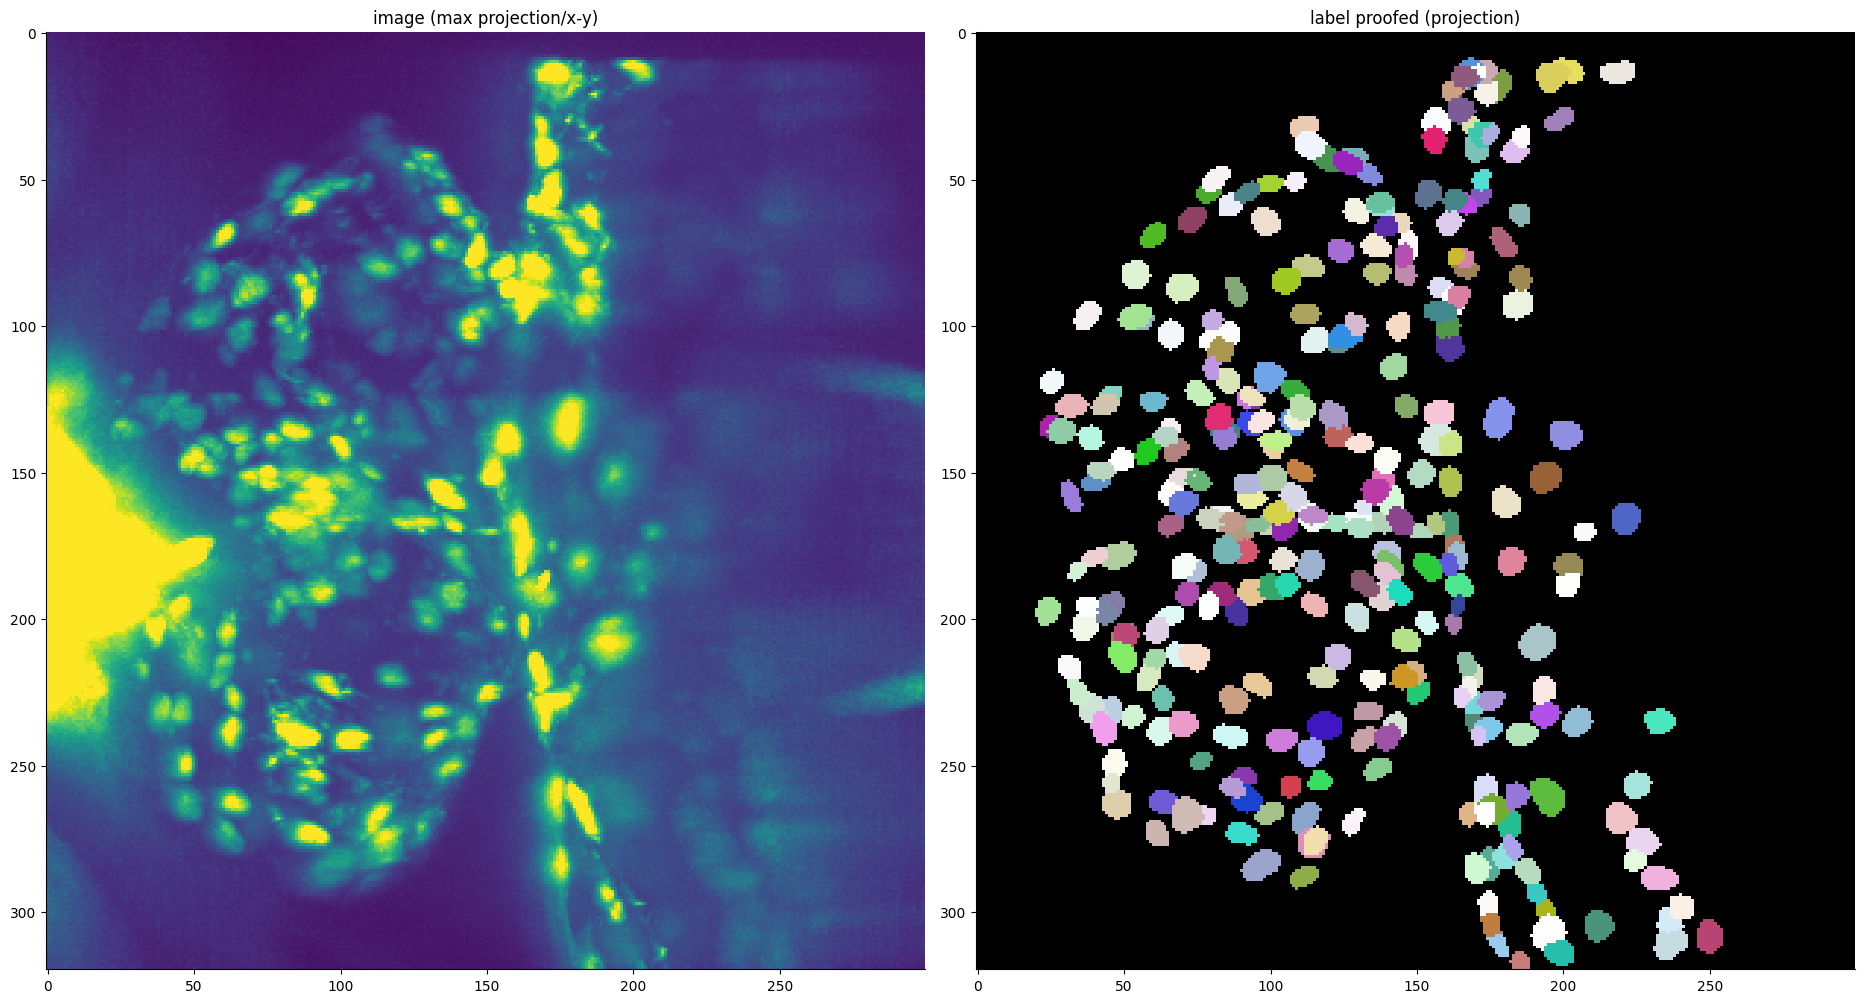

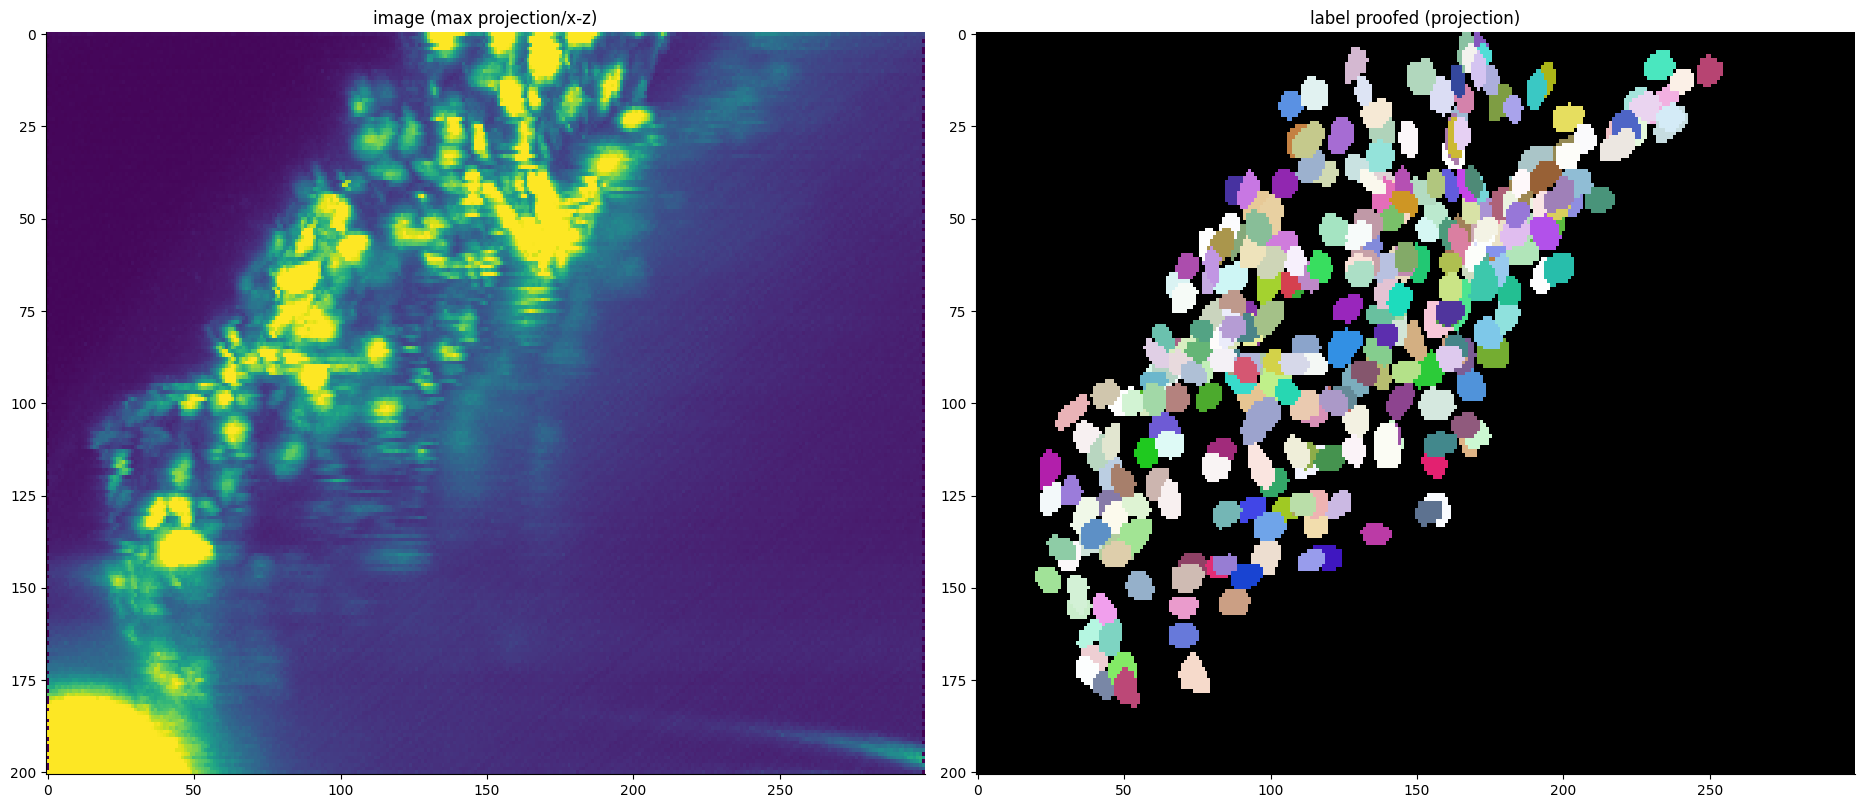

In [9]:
voxel_size=(0.729, 0.729, 1.26) # x y and z sizes of the voxel in micron
manual_seg_path="./worm1/manual_vol1/*.tif"

coords2image = cit.CoordsToImageTransformer(results_folder=path_results, voxel_size=voxel_size)
coords2image.load_segmentation(manual_seg_path)
sdw.plot_img_label_max_projection(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800)
sdw.plot_img_label_max_projection_xz(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800, scale_z=scale_z)

## Perform interpolation along z axis
## Parameters
interpolation_factor: An integer parameter (>= 1) that specifies the factor by which the number of z-slices in the original 3D image should be increased. For example, if the original image has 10 z-slices and factor is set to 2, then the new image will have 20 z-slices.
## Notes
The interpolated results are used to refine the positions of the tracking results. Increasing the number of z-slices via interpolation can improve the accuracy of the estimated cell positions.

The program employs a Gaussian blur filter to generate the interpolation. Even if the interpolation_factor is set to 1, the program still applies the filter without increasing the number of slices.

Interpolating images along z-axis...
The interpolated segmentations at vol 1 contains 310 cells
Calculating coordinates of cell centers...


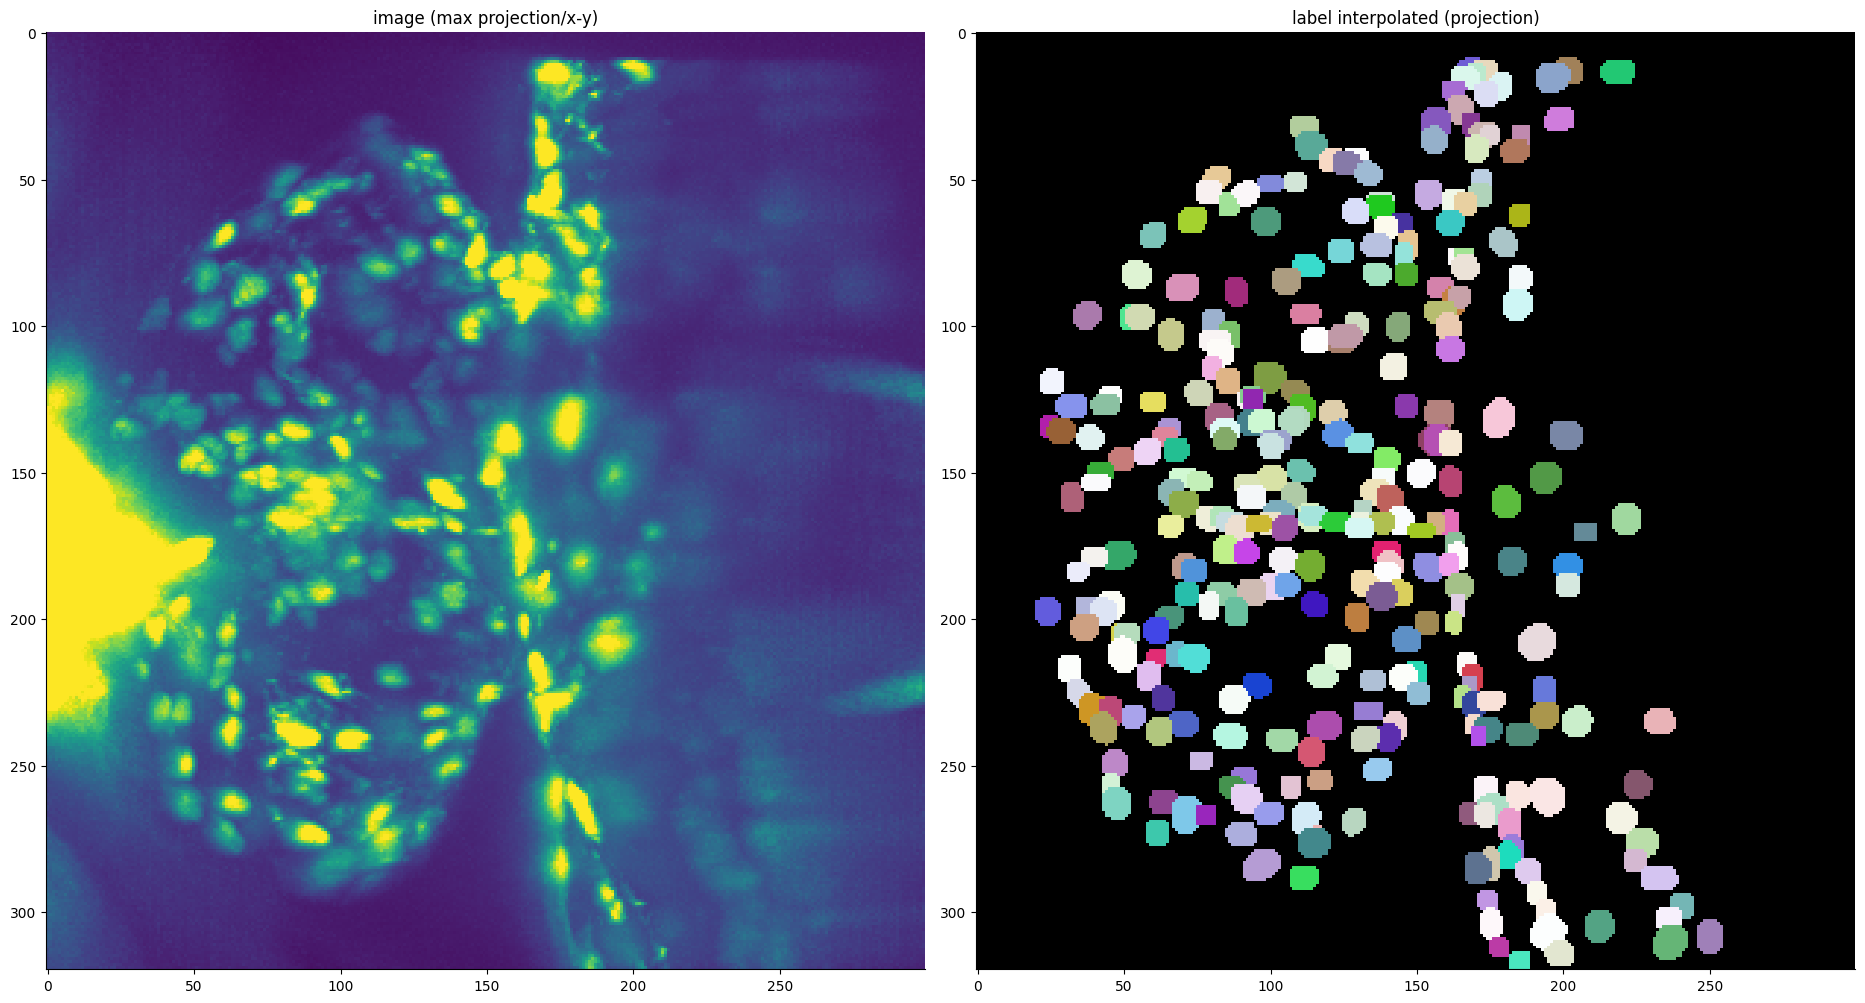

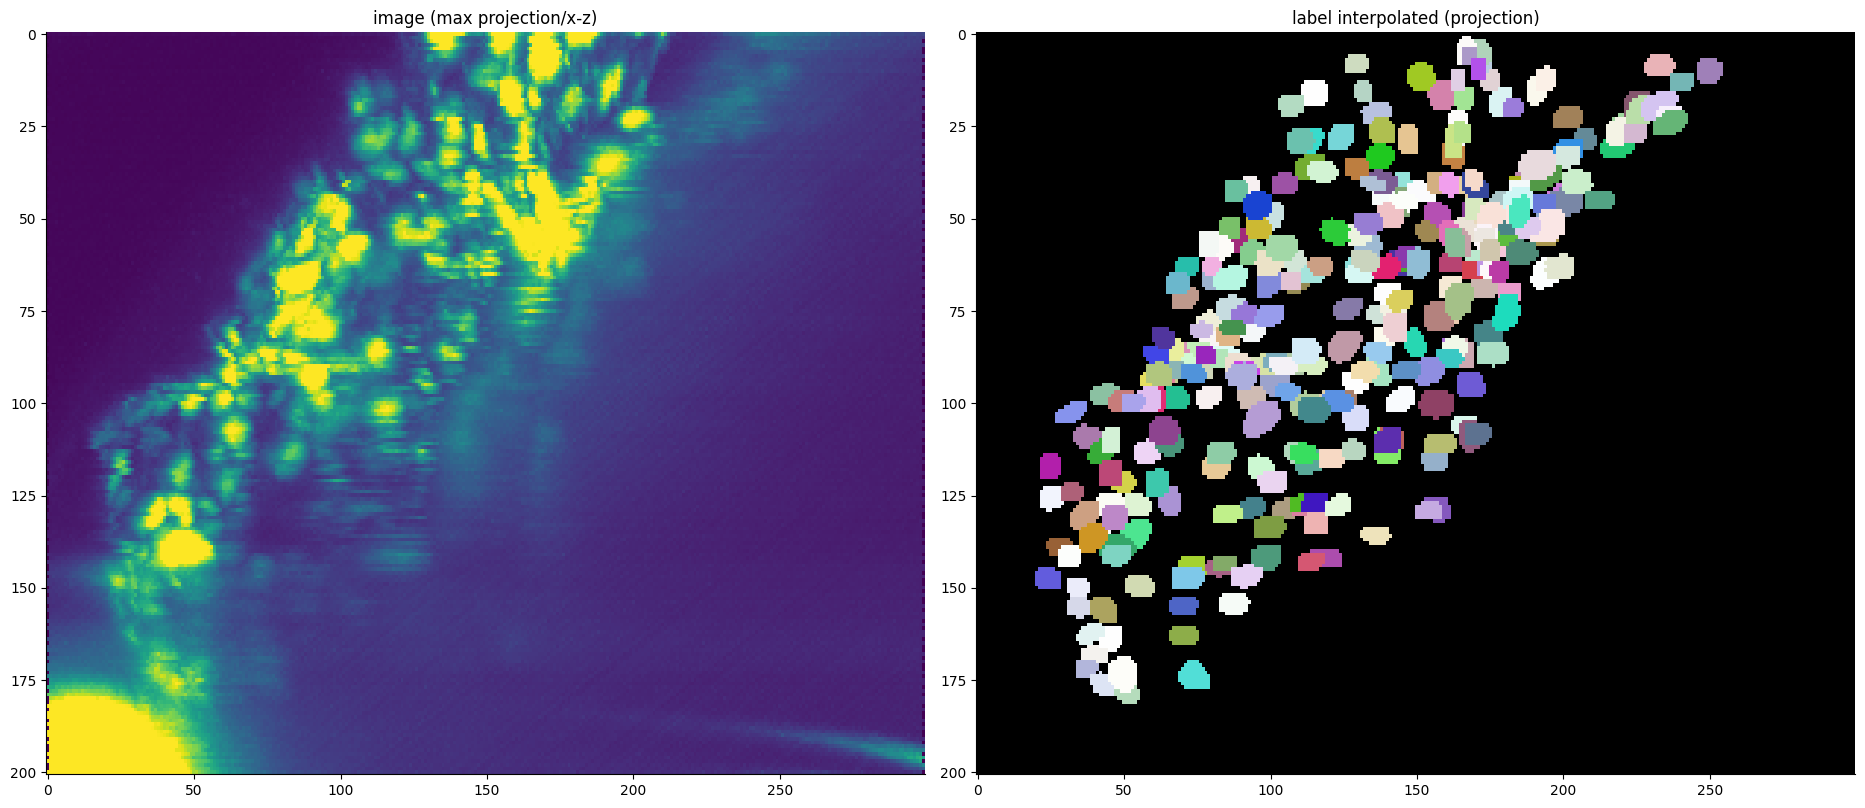

In [10]:
interpolation_factor = 10

coords2image.interpolate(interpolation_factor=interpolation_factor)
sdw.plot_img_label_max_projection(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800)
sdw.plot_img_label_max_projection_xz(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800,scale_z=scale_z)

# D - Tracking cells.
## Initiate Tracker
## Parameters
ffn_model_name: A string specifying the name of the ffn model to reload.
## Notes:
By default, the function looks for the model with the specified name from the "ffn_models" directory. However, if you have saved the model in a different location, you can specify the basedir parameter to load the model from that directory.

    tracker = trl.TrackerLite(results_dir=path_results, ffn_model_name=ffn_model_name, proofed_coords_vol1=coords2image.coord_vol1, basedir=".\FolderA\FolderB\")

In [12]:
import os

os.listdir('ffn_models')

['ffn_worm4.h5',
 'ffn_worm4_0001.h5',
 '.ipynb_checkpoints',
 'ffn_worm3.h5',
 'weights']

In [11]:
ffn_model_name="ffn_worm3"

tracker = trl.TrackerLite(results_dir=path_results, ffn_model_name=ffn_model_name, proofed_coords_vol1=coords2image.coord_vol1, basedir="ffn_models")

## Test FFN matching
## Parameters
t1: An integer specifying the volume number of the first segmentation
    
t2: An integer specifying the volume number of the second segmentation
## Notes:
The program will match the segmented cell centers points (saved in the "seg" folder) between volumes t1 and t2.

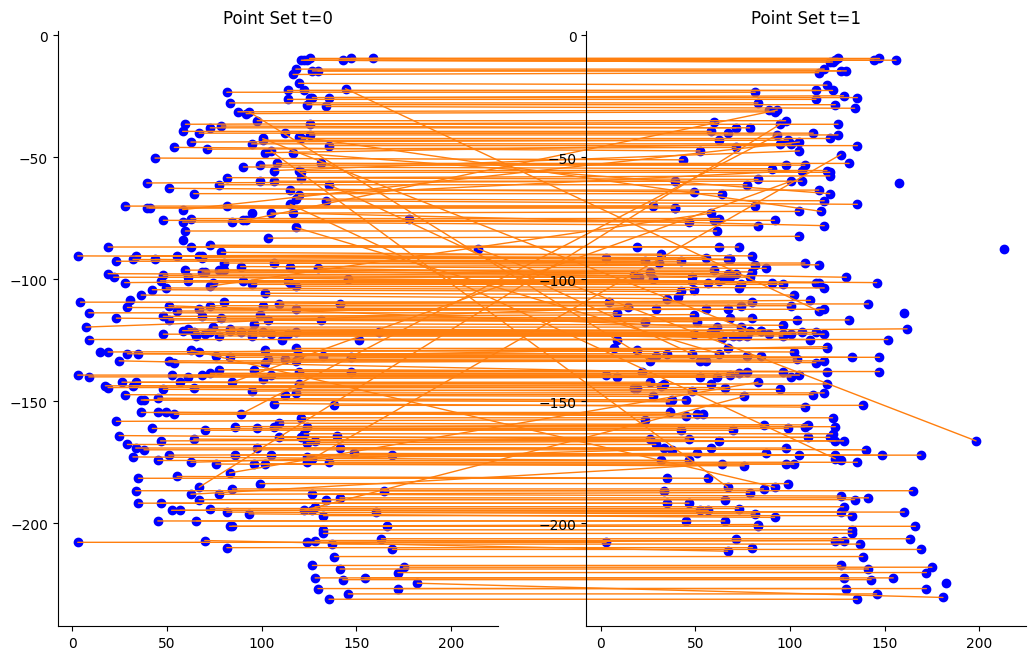

In [12]:
t1 = 0
t2 = 1

tracker.match_by_ffn(t1=t1, t2=t2)

## Test FFN + PR-GLS tracking
## Parameters
beta: A numeric value (integer or float). A larger value will result in a larger window for estimating cell movement based on neighboring cells.

lambda_: A numeric value (integer or float). A larger value will result in more similar movements across different cells.
## Notes:
The program will estimate the new positions at time point t2 for all cells segmented at time point t1. The FFN matching will be improved by PR-GLS to generate a more coherent estimation of cell movements.

The default values of beta and lambda_ are (3, 3), which are suitable for most cases. However, users can try different values to further improve the tracking.

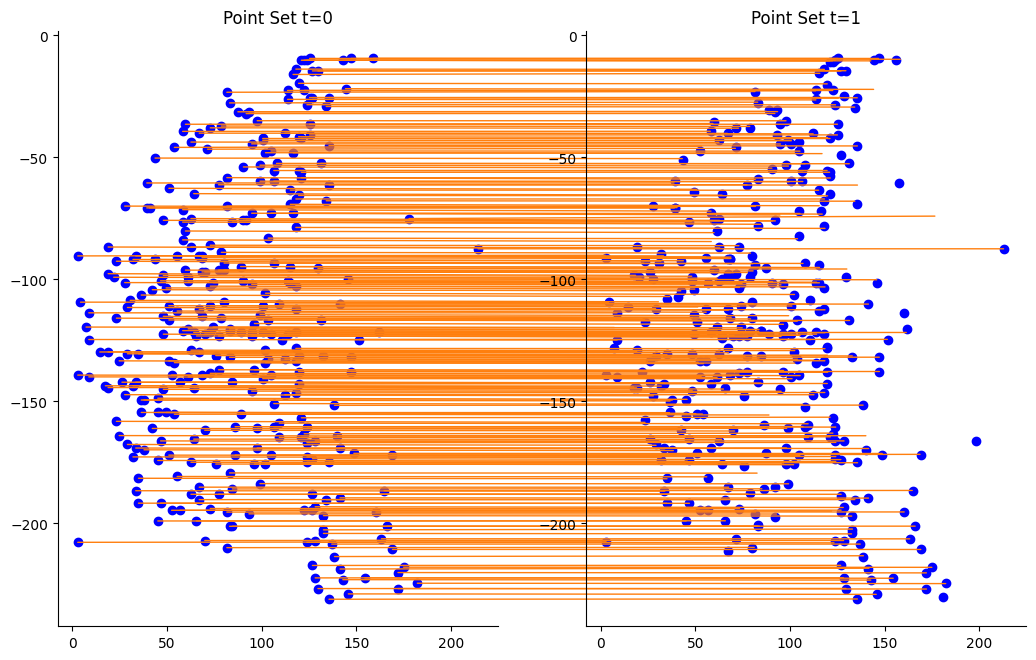

In [13]:
beta = 3
lambda_= 3

tracked_positions_t2 = tracker.predict_cell_positions(t1=0, t2=1, beta=beta, lambda_=lambda_, draw_fig=True)

## Track cells in following volumes in single mode
## Parameters
t_start: An integer specifying the volume number of the first raw image. Usually, this value is set to 1, so that the program will load coordinates in volume 2, 3, 4, and so on for tracking. If t_start is not 1, then the subsequent volume numbers will be t_start + 1, t_start + 2, and so on.

t_end: An integer specifying the volume number of the last raw image that should be tracked.

skipped_volumes: A list of integers specifying the volumes that should be skipped during tracking. An empty list [] means no volume will be skipped.
## Notes:

All tracking results will be automatically saved in the "track_results" folder, including:

1. The coordinates of tracked cells (in the same units as the voxel_size) - Folder "coords_real"
2. Figures showing the tracking in each volume - Folder "figure"
3. Images of the tracked labels in each volume - Folder "labels"
4. Merged images of the raw image and the tracked labels in each volume, projected on the x-y plane - Folder "merged_labels"
5. Merged images of the raw image and the tracked labels in each volume, projected on the x-z plane - Folder "merged_labels_xz"

In [14]:
import time

start_time = time.time()

t_start = 0
t_end = 91
skipped_volumes = []

ensemble = False
t1 = t_start
confirmed_coord = coords2image.coord_vol1
grid = model.config.grid
for t in range(t_start+1, t_end+1):
    print(f"t={t}...", end="\r")
    if t in skipped_volumes:
        print(f"skip t={t}")
        continue
    coord_prgls = tracker.predict_cell_positions(t1=t1, t2=t, confirmed_coord_t1=confirmed_coord, beta=beta, lambda_=lambda_, draw_fig=False)
    confirmed_coord, corrected_labels_image = coords2image.accurate_correction(t, grid, coord_prgls, ensemble=ensemble)
    coords2image.save_tracking_results(confirmed_coord, corrected_labels_image, tracker, t1=t1, t2=t, images_path=path_raw_images)
    t1 = t

    
end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_img = (320, 300)
raw_img_xz = (2010, 300)
labels_rgb = (320, 300, 3)
labels_rgb_xz = (2010, 300, 3)
raw_im

# E - Extract activities from tracked cells
## Extract activities
## Parameters
raw_path: A string specifying the file path to the raw image to extract the activities. The image data should be in TIFF format.
## Notes
This Code Block extracts activities from 3D time-lapse images, based on tracking results.

In [16]:
import time

start_time = time.time()

raw_path = "./worm1/data/*t%03d*.tif"

activities = tracker.activities(raw_path=raw_path)

end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

Execution time: 380.72374534606934 secondes


## Draw a figure to show the activities

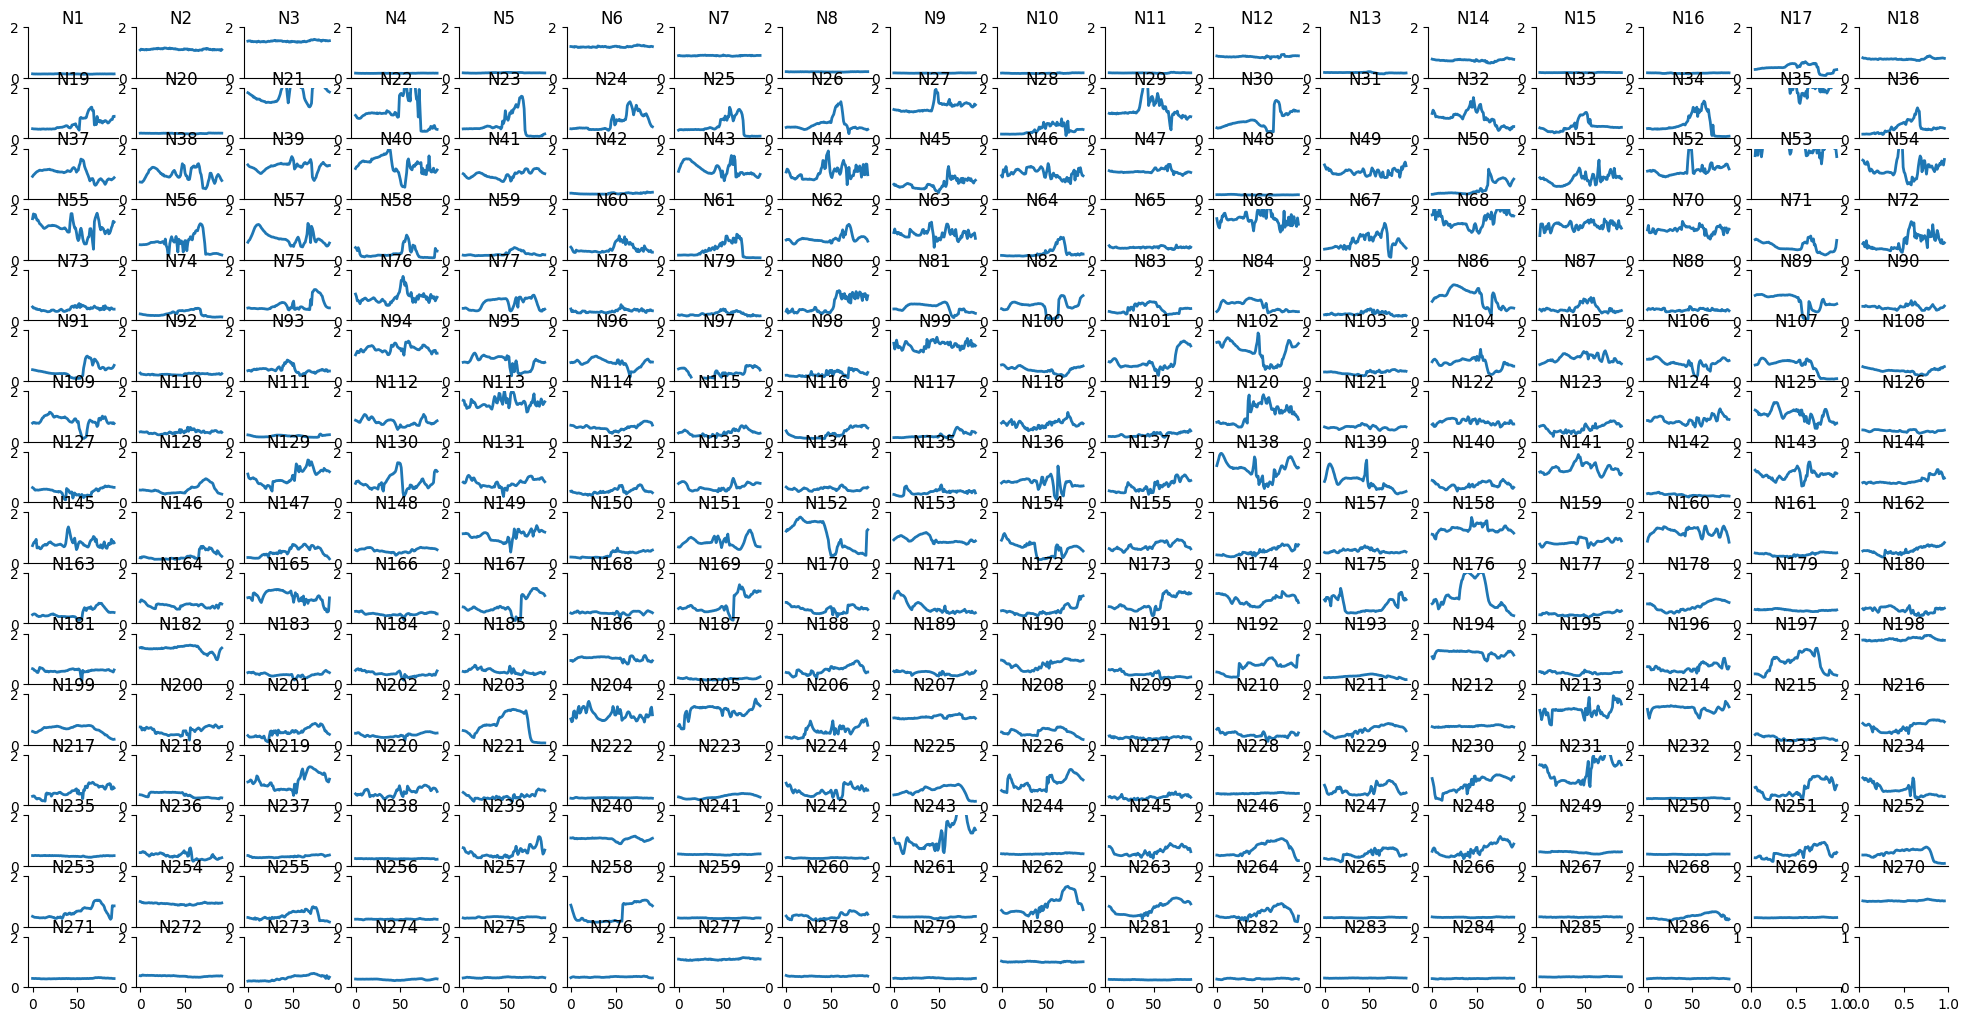

In [17]:
draw_signals(activities, ylim_lower=0, ylim_upper=2, figsize=(20, 10))

## Export the activities as csv file
## Parameters
csv_filename: The filename of the csv file to save the extracted activities

In [18]:
csv_filename = "activities_txcell.csv"

csv_filename = os.path.join(path_results, csv_filename)
timings = np.arange(1, activities.shape[0]+1).reshape(-1, 1)
activities_with_timings = np.concatenate((timings, activities), axis=1)
headers = ['timing'] + ['cell' + str(i) for i in range(1, activities.shape[1]+1)]
np.savetxt(csv_filename, activities_with_timings, delimiter=',', fmt='%.3f', header=','.join(headers), comments='')
print(f"The cell activities have been saved in {csv_filename}")

The cell activities have been saved in ./worm1/activities_txcell.csv


# F - Build the 3D time-lapse labelled image

In [2]:
import skimage.io as io
import numpy as np
import imageio

ffn_model_name="ffn_worm3"

# Initialize a list to store the data
slices_dataset = []

# Loop through the t values
for t in range(0, length_cycle_with_max_freq):
    # Initialise a list to store the slices for each t
    slices_at_t = []
    
    # Loop through the z values
    for z in range(1, num_slices+1):
        # Construct the path to the tiff file
        tiff_file_path = f"worm1/track_results/labels/track_results_t{t:06}_z{z:04}.tif"
        
        # Load the data from the tiff file
        tiff_data = imageio.volread(tiff_file_path)
        
        # Add the data to the list of slices for this t
        slices_at_t.append(tiff_data)
    
    # Add the slices for this t to the overall dataset
    slices_dataset.append(slices_at_t)

# Convert the list to a NumPy array
slices_dataset = np.array(slices_dataset)

# Rearrange the array to have the desired dimensions
slices_dataset = slices_dataset.transpose((1, 0, 2, 3))

# Check the dimensions of the array
# print(slices_dataset.shape)
slices_dataset = np.asarray(slices_dataset)  # TZYX
slices_dataset = np.array(slices_dataset)  # TZYX
slices_dataset = np.expand_dims(slices_dataset, axis=2)  # TZCYX
slices_dataset = np.swapaxes(slices_dataset, 0, 1)  # ZTCYX
print(slices_dataset.shape)

# Save the array as a tiff image
io.imsave(f'labeled3D_with_time_image_LoG_{ffn_model_name}.ome.tif', slices_dataset.astype('uint16'), imagej=True)


(92, 201, 1, 320, 300)
